# Import and setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux, KerrEccEqFlux
# from few.amplitude.romannet import RomanAmplitude
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum, CubicSplineInterpolant


from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few import get_file_manager

from few.waveform import (
    FastKerrEccentricEquatorialFlux,
    FastSchwarzschildEccentricFlux, 
    SlowSchwarzschildEccentricFlux, 
    Pn5AAKWaveform,
    GenerateEMRIWaveform
)

from few.utils.geodesic import get_fundamental_frequencies

import GWfuncs
import gc
import pickle
import os
import cupy as cp
import multiprocessing as mp
from multiprocessing import Queue, Process
from functools import partial
from SNR_tutorial_utils import LISA_Noise
from lisatools.sensitivity import *

from few.utils.constants import YRSID_SI, Gpc, MRSUN_SI



# import pandas as pd
# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info");

# Generating waveforms with FEW func

In [2]:
%%time
# Parameters
m1 = 1e6 #M
m2 = 1e1 #mu
a = 0.5
p0 = 9.5
e0 = 0.2
theta = np.pi / 3.0 
phi = np.pi / 4.0  
dt = 10.0
T = 1
xI0 = 1.0 
dist = 1 #Gpc
#in the paper xI0 = 0.866, but that would be non-equatorial case

use_gpu = True 
func = "KerrEccentricEquatorial"
cp.cuda.Stream.null.synchronize()

CPU times: user 13 ms, sys: 243 ms, total: 256 ms
Wall time: 291 ms


In [4]:
%%time
# keyword arguments for inspiral generator 
inspiral_kwargs={
        "func": 'KerrEccEqFlux',
        "DENSE_STEPPING": 0, #change to 1/True for uniform sampling
        "include_minus_m": False, 
        "use_gpu" : use_gpu,
        "force_backend": "cuda12x"  # Force GPU
}

# keyword arguments for inspiral generator 
amplitude_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
    # "use_gpu" : use_gpu
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
    # "assume_positive_m": True  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
    "pad_output": False,
    # "use_gpu" : use_gpu
}

# Kerr eccentric flux
waveform_gen = FastKerrEccentricEquatorialFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)
cp.cuda.Stream.null.synchronize()

CPU times: user 8.5 s, sys: 5.48 s, total: 14 s
Wall time: 23.8 s


In [5]:
%%timeit
h_true = waveform_gen(m1, m2, a, p0, e0, xI0, theta, phi, dist=dist, dt=dt, T=1)
cp.cuda.Stream.null.synchronize()

135 ms ± 589 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%time
h_true = waveform_gen(m1, m2, a, p0, e0, xI0, theta, phi, dist=dist, dt=dt, T=1)
cp.cuda.Stream.null.synchronize()

CPU times: user 143 ms, sys: 5.45 ms, total: 149 ms
Wall time: 146 ms


In [9]:
N = int(len(h_true)) 
print(N)
gwf = GWfuncs.GravWaveAnalysis(N=N,dt=dt)

3155815


In [10]:
factor = gwf.dist_factor(dist, m2)


# Selecting modes (purely by NON-noise-weighted power)

In [12]:
traj = EMRIInspiral(func=KerrEccEqFlux, force_backend="cuda12x", use_gpu=use_gpu) #theres npoints flag here
amp = AmpInterpKerrEccEq(force_backend="cuda12x") # default lmax=10, nmax=55
interpolate_mode_sum = InterpolatedModeSum(force_backend="cuda12x")
ylm_gen = GetYlms(include_minus_m=False, force_backend="cuda12x")

In [13]:
# Get mode labels
mode_labels = [f"({l},{m},{n})" for l,m,n in zip(amp.l_arr, amp.m_arr, amp.n_arr)]

In [14]:
%%time 
# Calc trajectory
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=dt) #False

# Get amplitudes along trajectory
teuk_modes = amp(a, p, e, x)

# Get Ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

cp.cuda.Stream.null.synchronize()

CPU times: user 20 ms, sys: 5.69 ms, total: 25.7 ms
Wall time: 22.9 ms


In [15]:
m0mask = amp.m_arr_no_mask != 0
# Calculate power for all modes
total_power = gwf.calc_power(teuk_modes, ylms, m0mask)

In [16]:
total_power_cpu = total_power.get()

In [17]:
# Bar plot of modes vs approx inner product for top M modes 
M_mode = 10
mp = list(zip(mode_labels, total_power_cpu)) 
# Sort by power and pick top M modes
mp_sorted = sorted(mp, key=lambda x: x[1], reverse=True)[:M_mode]
mp_modes = [x[0] for x in mp_sorted]
mp_power = [x[1] for x in mp_sorted]

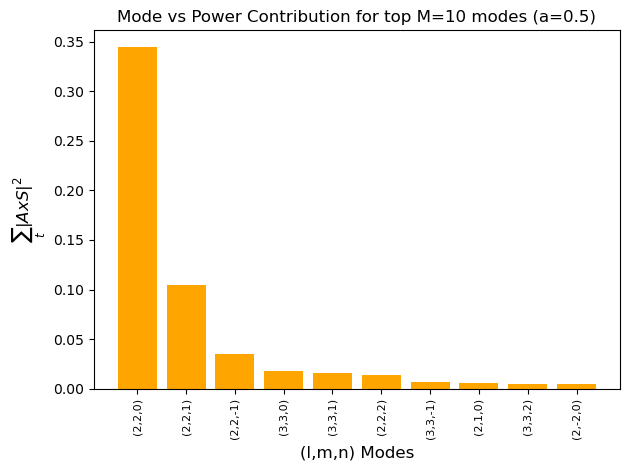

In [18]:
plt.bar(range(len(mp_power)), mp_power, color='orange')
plt.xticks(range(len(mp_modes)), mp_modes, rotation=90, fontsize=8)
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'$\sum_{t} |AxS|^2$', fontsize=12)
plt.title('Mode vs Power Contribution for top M={} modes (a={})'.format(M_mode,a), fontsize=12)
plt.yscale('linear')
plt.tight_layout()
plt.show()

In [19]:
# Pick modes based on top M power contributions
top_indices = [mode_labels.index(mode) for mode in mp_modes]
print("Top mode indices:", top_indices)


Top mode indices: [1165, 1166, 1164, 1498, 1499, 1167, 1497, 1054, 1500, 7159]


# Generating mode-forms with FEW func

In [22]:
t_gpu = cp.asarray(t)

In [28]:
%%timeit
waveform_per_mode = []
for idx in top_indices:
    l = amp.l_arr[idx]
    m = amp.m_arr[idx]
    n = amp.n_arr[idx]
    # print('Mode: ', mode_labels[idx])

    if m >= 0:
        # For m >= 0, directly use the mode
        teuk_modes_single = teuk_modes[:, [idx]]
        ylms_single = ylms[[idx]]
        m_arr = amp.m_arr[[idx]]
    else:
        # Finding corresponding m>0 mode instead of mapping
        # print('NEGATIVE M MODE')
        pos_m_mask = (amp.l_arr == l) & (amp.m_arr == -m) & (amp.n_arr == n) 
        # print(amp.l_arr[pos_m_mask], amp.m_arr[pos_m_mask], amp.n_arr[pos_m_mask])
        pos_m_idx = np.where(pos_m_mask)[0]
        # print(pos_m_idx)
        
        teuk_modes_single = (-1)**l * np.conj(teuk_modes[:, [pos_m_idx]])
        # print(teuk_modes_single)
        # ylms_single = (-1)**(-m) * np.conj(ylms[[pos_m_idx]])
        ylms_single = ylms[[idx]]
        # print(ylms_single)
        m_arr = np.abs(amp.m_arr[[idx]])  # To pass positive m 

    waveform = interpolate_mode_sum(
        t_gpu,
        teuk_modes_single,
        ylms_single,
        traj.integrator_spline_t,
        traj.integrator_spline_phase_coeff[:, [0, 2]],
        amp.l_arr[[idx]],
        m_arr,  
        amp.n_arr[[idx]], 
        dt=dt,
        T=T
    )
    waveform_per_mode.append(waveform/factor)
cp.cuda.Stream.null.synchronize()

41.4 ms ± 24.1 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
%%time
waveform_per_mode = []
for idx in top_indices:
    l = amp.l_arr[idx]
    m = amp.m_arr[idx]
    n = amp.n_arr[idx]
    # print('Mode: ', mode_labels[idx])

    if m >= 0:
        # For m >= 0, directly use the mode
        teuk_modes_single = teuk_modes[:, [idx]]
        ylms_single = ylms[[idx]]
        m_arr = amp.m_arr[[idx]]
    else:
        # Finding corresponding m>0 mode instead of mapping
        # print('NEGATIVE M MODE')
        pos_m_mask = (amp.l_arr == l) & (amp.m_arr == -m) & (amp.n_arr == n) 
        # print(amp.l_arr[pos_m_mask], amp.m_arr[pos_m_mask], amp.n_arr[pos_m_mask])
        pos_m_idx = np.where(pos_m_mask)[0]
        # print(pos_m_idx)
        
        teuk_modes_single = (-1)**l * np.conj(teuk_modes[:, [pos_m_idx]])
        # print(teuk_modes_single)
        # ylms_single = (-1)**(-m) * np.conj(ylms[[pos_m_idx]])
        ylms_single = ylms[[idx]]
        # print(ylms_single)
        m_arr = np.abs(amp.m_arr[[idx]])  # To pass positive m 

    waveform = interpolate_mode_sum(
        t_gpu,
        teuk_modes_single,
        ylms_single,
        traj.integrator_spline_t,
        traj.integrator_spline_phase_coeff[:, [0, 2]],
        amp.l_arr[[idx]],
        m_arr,  
        amp.n_arr[[idx]], 
        dt=dt,
        T=T
    )
    waveform_per_mode.append(waveform/factor)
cp.cuda.Stream.null.synchronize()

CPU times: user 33 ms, sys: 12.8 ms, total: 45.7 ms
Wall time: 44.5 ms


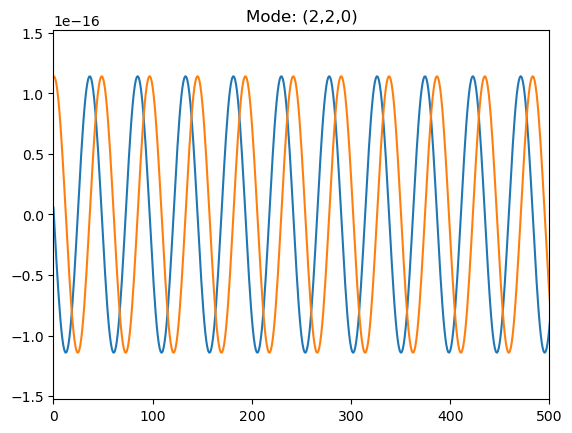

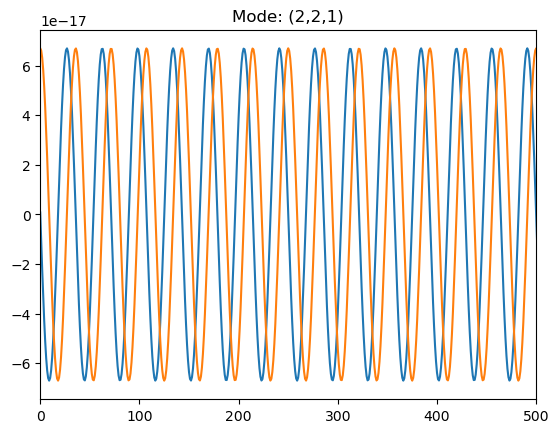

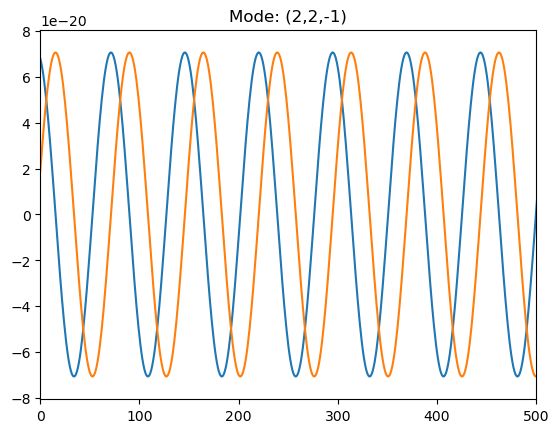

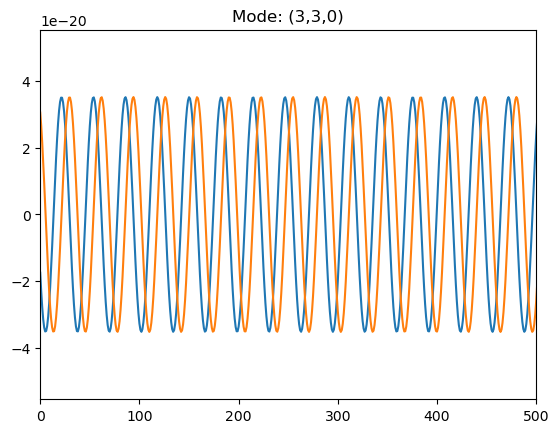

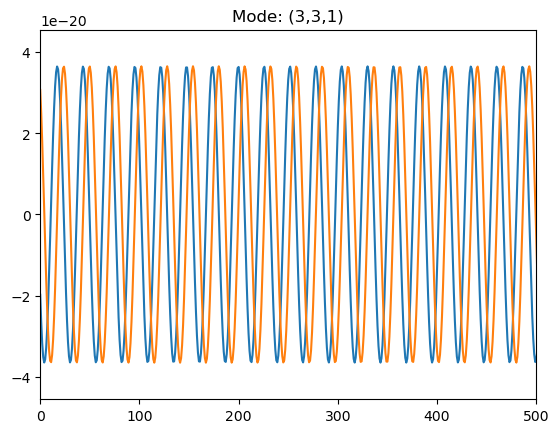

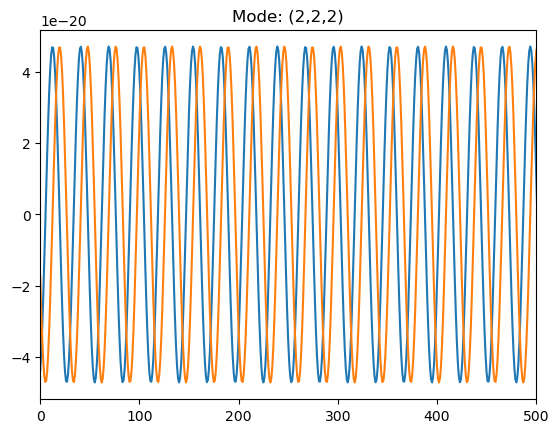

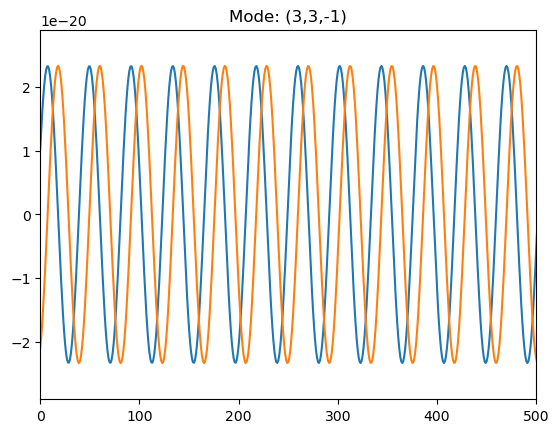

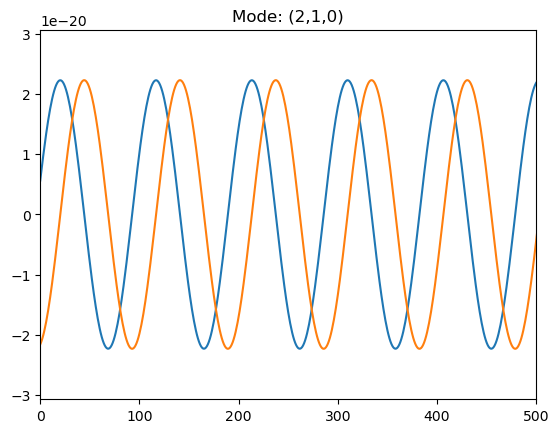

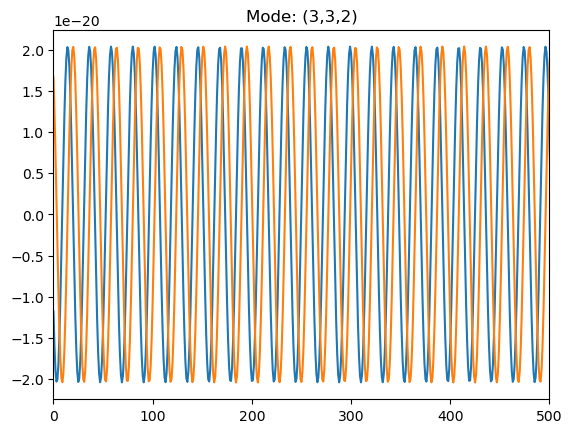

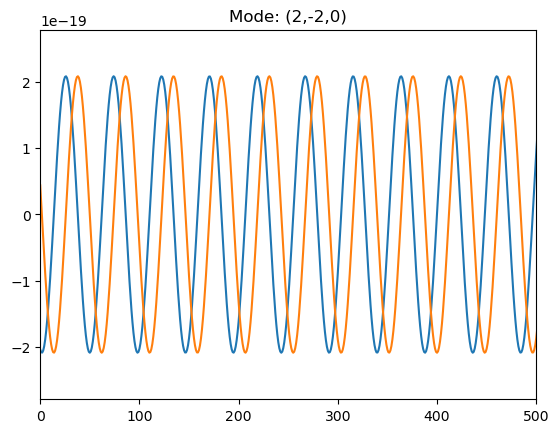

In [31]:
for i, mode_idx in enumerate(top_indices):
    # print(i, mode_idx)
    modeform = waveform_per_mode[i].get()
    plt.plot(modeform.real)
    plt.plot(modeform.imag)
    plt.title(f"Mode: {mode_labels[mode_idx]}")
    plt.xlim(0,500)
    plt.show()